In [1]:
#@title Initialization
import os
import itertools
import csv
import torch
from matplotlib.pyplot import *
from torch import nn
from functorch import vmap, grad, hessian
from math import pi
from time import time
# from google.colab import drive
# drive.mount('/content/drive')
# os.chdir('/content/drive/MyDrive/Аппроксимация средствами PyTorch')
device = 'cpu'


class HelmholtzSolver(nn.Module):
    def __init__(self, ndims, N, L, activation, bounds, g=lambda x: 0):
        super(HelmholtzSolver, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(ndims, N), activation,
            *[nn.Linear(N, N), activation]*(L-1),
            nn.Linear(N, 1),
        )
        self.bounds = bounds
        self.g = g


    def forward(self, x):
        # enforce boundary condition
        return self.g(x) + torch.prod((x-self.bounds[0])*(self.bounds[1]-x), -1, True)*self.layers(x)


class Sin(nn.Module):
    def __init__(self):
        super().__init__()


    def forward(self, x):
        return torch.sin(x)


def RMSELoss(pred,y):
    return torch.sqrt(torch.mean((pred-y)**2))

In [ ]:
#@title Incorrect implementation
def loss_fn(x, u, f=lambda x: 0):
    d1 = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    d2 = torch.autograd.grad(d1, x, grad_outputs=torch.ones_like(d1), create_graph=True)[0]
    return torch.sum((torch.sum(d2, 1, True) + u + f(x))**2)/len(u)


def train(model, optimizer, x, f=lambda x: 0, batch_size=1):
    model.train()
    timestamp = time()
    for i in range(0, len(x), batch_size):
        x_batch = x[i:i+batch_size].requires_grad_()
        pred = model(x_batch)
        loss = loss_fn(x_batch, pred, f)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Display progress
        if time() - timestamp >= 1:
            print(f'[{i+batch_size}/{len(x)}]', end='\r')
            timestamp = time()
            
            
def test(model, x, u, f=lambda x: 0, batch_size=1):
    model.eval()
    loss = 0
    pred_list = []
    for i in range(0, len(x), batch_size):
        x_batch = x[i:i+batch_size].requires_grad_()
        pred = model(x_batch)
        loss += loss_fn(x_batch, pred, f).item()*len(x_batch)
        pred_list.append(pred.detach())
    pred = torch.cat(pred_list)
    loss /= len(x)
    RMSE = RMSELoss(pred, u).item()
    return loss, RMSE

In [ ]:
#@title Implementation using torch.autograd.grad
def loss_fn(x, u, f=lambda x: 0):
    d1 = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    d2 = torch.stack([torch.autograd.grad(d1[:,i], x, grad_outputs=torch.ones_like(d1[:,i]), create_graph=True)[0][:,i] for i in range(d1.size()[1])], 1)
    return torch.sum((torch.sum(d2, 1, True) + u + f(x))**2)/len(u)


def train(model, optimizer, x, f=lambda x: 0, batch_size=1):
    model.train()
    timestamp = time()
    for i in range(0, len(x), batch_size):
        x_batch = x[i:i+batch_size].requires_grad_()
        pred = model(x_batch)
        loss = loss_fn(x_batch, pred, f)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Display progress
        if time() - timestamp >= 1:
            print(f'[{i+batch_size}/{len(x)}]', end='\r')
            timestamp = time()
            
            
def test(model, x, u, f=lambda x: 0, batch_size=1):
    model.eval()
    loss = 0
    pred_list = []
    for i in range(0, len(x), batch_size):
        x_batch = x[i:i+batch_size].requires_grad_()
        pred = model(x_batch)
        loss += loss_fn(x_batch, pred, f).item()*len(x_batch)
        pred_list.append(pred.detach())
    pred = torch.cat(pred_list)
    loss /= len(x)
    RMSE = RMSELoss(pred, u).item()
    return loss, RMSE

In [2]:
#@title Implementation using functorch.hessian
laplacian = lambda u, x: torch.sum(torch.diagonal(vmap(hessian(u))(x), dim1=-2, dim2=-1), -1)


def loss_fn(model, x, u, f=lambda x: 0):
    return torch.sum((laplacian(model, x) + u + f(x))**2)/len(u)


def train(model, optimizer, x, f=lambda x: 0, batch_size=1):
    model.train()
    timestamp = time()
    for i in range(0, len(x), batch_size):
        x_batch = x[i:i+batch_size]
        pred = model(x_batch)
        loss = loss_fn(model, x_batch, pred, f)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Display progress
        if time() - timestamp >= 1:
            print(f'[{i+batch_size}/{len(x)}]', end='\r')
            timestamp = time()
            
            
def test(model, x, u, f=lambda x: 0, batch_size=1):
    model.eval()
    loss = 0
    pred_list = []
    for i in range(0, len(x), batch_size):
        x_batch = x[i:i+batch_size]
        pred = model(x_batch)
        loss += loss_fn(model, x_batch, pred, f).item()*len(x_batch)
        pred_list.append(pred.detach())
    pred = torch.cat(pred_list)
    loss /= len(x)
    RMSE = RMSELoss(pred, u).item()
    return loss, RMSE

In [ ]:
#@title Implementation using functorch.jacfwd
from functorch import jacfwd
laplacian = lambda u, x: torch.sum(torch.diagonal(vmap(jacfwd(jacfwd(u)))(x), dim1=-2, dim2=-1), -1)


def loss_fn(model, x, u, f=lambda x: 0):
    return torch.sum((laplacian(model, x) + u + f(x))**2)/len(u)


def train(model, optimizer, x, f=lambda x: 0, batch_size=1):
    model.train()
    timestamp = time()
    for i in range(0, len(x), batch_size):
        x_batch = x[i:i+batch_size]
        pred = model(x_batch)
        loss = loss_fn(model, x_batch, pred, f)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Display progress
        if time() - timestamp >= 1:
            print(f'[{i+batch_size}/{len(x)}]', end='\r')
            timestamp = time()
            
            
def test(model, x, u, f=lambda x: 0, batch_size=1):
    model.eval()
    loss = 0
    pred_list = []
    for i in range(0, len(x), batch_size):
        x_batch = x[i:i+batch_size]
        pred = model(x_batch)
        loss += loss_fn(model, x_batch, pred, f).item()*len(x_batch)
        pred_list.append(pred.detach())
    pred = torch.cat(pred_list)
    loss /= len(x)
    RMSE = RMSELoss(pred, u).item()
    return loss, RMSE

In [ ]:
#@title Implementation using functorch.grad
laplacian = lambda u, x: torch.sum(vmap(lambda x: torch.stack([grad(grad(lambda *x: u(torch.stack(x)).squeeze(), argnums=i), argnums=i)(*x) for i in range(len(x))]))(x), -1, True)


def loss_fn(model, x, u, f=lambda x: 0):
    return torch.sum((laplacian(model, x) + u + f(x))**2)/len(u)


def train(model, optimizer, x, f=lambda x: 0, batch_size=1):
    model.train()
    timestamp = time()
    for i in range(0, len(x), batch_size):
        x_batch = x[i:i+batch_size]
        pred = model(x_batch)
        loss = loss_fn(model, x_batch, pred, f)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Display progress
        if time() - timestamp >= 1:
            print(f'[{i+batch_size}/{len(x)}]', end='\r')
            timestamp = time()
            
            
def test(model, x, u, f=lambda x: 0, batch_size=1):
    model.eval()
    loss = 0
    pred_list = []
    for i in range(0, len(x), batch_size):
        x_batch = x[i:i+batch_size]
        pred = model(x_batch)
        loss += loss_fn(model, x_batch, pred, f).item()*len(x_batch)
        pred_list.append(pred.detach())
    pred = torch.cat(pred_list)
    loss /= len(x)
    RMSE = RMSELoss(pred, u).item()
    return loss, RMSE

In [ ]:
#@title Manual implementation
def laplacian(x):
    z = [model.layers[0].weight @ x + model.layers[0].bias]
    y = [torch.sin(z[0])]
    dy1 = [torch.cos(z[0]).unsqueeze(1) * model.layers[0].weight]
    dy2 = [-torch.sin(z[0]).unsqueeze(1) * model.layers[0].weight**2]
    for i in range(1, L):
        z.append(model.layers[2*i].weight @ y[i-1] + model.layers[2*i].bias)
        y.append(torch.sin(z[i]))
        dy1.append(torch.cos(z[i]).unsqueeze(1) * model.layers[2*i].weight @ dy1[i-1])
        dy2.append(-torch.sin(z[i]).unsqueeze(1) * (model.layers[2*i].weight @ dy1[i-1])**2 + torch.cos(z[i]).unsqueeze(1) * model.layers[2*i].weight @ dy2[i-1])
    y.append(model.layers[-1].weight @ y[-1] + model.layers[-1].bias)
    dy1.append((model.layers[-1].weight @ dy1[-1]).squeeze(0))
    dy2.append((model.layers[-1].weight @ dy2[-1]).squeeze(0))

    a = model.bounds[0]
    b = model.bounds[1]
    dg2 = 0
    du2 = dg2 + torch.prod(((x-a)*(b-x)).repeat(len(x), 1).fill_diagonal_(1), 1)*(-2*y[-1] + 2*(-2*x+a+b)*dy1[-1] + (-x**2+(a+b)*x-a*b)*dy2[-1])
    return torch.sum(du2, -1, True)


def laplacian_alt(x):
    z = [model.layers[0].weight @ x + model.layers[0].bias]
    y = [torch.sin(z[0])]
    dy1 = [torch.cos(z[0]).unsqueeze(1) * model.layers[0].weight]
    dy2 = [-torch.sin(z[0]).unsqueeze(1) * model.layers[0].weight**2]
    for i in range(1, L):
        z.append(model.layers[2*i].weight @ y[i-1] + model.layers[2*i].bias)
        y.append(torch.sin(z[i]))
        dy1.append(torch.cos(z[i]).unsqueeze(1) * model.layers[2*i].weight @ dy1[i-1])
        dy2.append(-torch.sin(z[i]).unsqueeze(1) * (model.layers[2*i].weight @ dy1[i-1])**2 + torch.cos(z[i]).unsqueeze(1) * model.layers[2*i].weight @ dy2[i-1])
    y.append(model.layers[-1].weight @ y[-1] + model.layers[-1].bias)
    dy1.append((model.layers[-1].weight @ dy1[-1]).squeeze(0))
    dy2.append((model.layers[-1].weight @ dy2[-1]).squeeze(0))

    a = model.bounds[0]
    b = model.bounds[1]
    prod_matrix = ((x-a)*(b-x)).repeat(len(x), 1)
    for i in range(len(x)):
        prod_matrix[i,i] = 1
    dg2 = 0
    du2 = dg2 + torch.prod(prod_matrix, 1)*(-2*y[-1] + 2*(-2*x+a+b)*dy1[-1] + (-x**2+(a+b)*x-a*b)*dy2[-1])
    return torch.sum(du2, -1, True)


def laplacian_multiactivation(x):
    if isinstance(activation, Sin):
        a = torch.sin
        da1 = lambda x: torch.cos(x)
        da2 = lambda x: -torch.sin(x)
    if isinstance(activation, nn.Tanh):
        a = torch.tanh
        da1 = lambda x: 1 - torch.tanh(x)**2
        da2 = lambda x: 2*torch.tanh(x)*(torch.tanh(x)**2 - 1)
    if isinstance(activation, nn.Sigmoid):
        a = torch.sigmoid
        da1 = lambda x: 1/(torch.exp(-x) + 2 + torch.exp(x))
        da2 = lambda x: (torch.exp(-x) - torch.exp(x))/(torch.exp(-x) + 2 + torch.exp(x))**2

    z = [model.layers[0].weight @ x + model.layers[0].bias]
    y = [a(z[0])]
    dy1 = [da1(z[0]).unsqueeze(1) * model.layers[0].weight]
    dy2 = [da2(z[0]).unsqueeze(1) * model.layers[0].weight**2]
    for i in range(1, L):
        z.append(model.layers[2*i].weight @ y[i-1] + model.layers[2*i].bias)
        y.append(a(z[i]))
        dy1.append(da1(z[i]).unsqueeze(1) * model.layers[2*i].weight @ dy1[i-1])
        dy2.append(da2(z[i]).unsqueeze(1) * (model.layers[2*i].weight @ dy1[i-1])**2 + da1(z[i]).unsqueeze(1) * model.layers[2*i].weight @ dy2[i-1])
    y.append(model.layers[-1].weight @ y[-1] + model.layers[-1].bias)
    dy1.append((model.layers[-1].weight @ dy1[-1]).squeeze(0))
    dy2.append((model.layers[-1].weight @ dy2[-1]).squeeze(0))

    b1 = model.bounds[0]
    b2 = model.bounds[1]
    prod_matrix = ((x-b1)*(b2-x)).repeat(len(x), 1)
    for i in range(len(x)):
        prod_matrix[i,i] = 1
    dg2 = 0
    du2 = dg2 + torch.prod(prod_matrix, 1)*(-2*y[-1] + 2*(-2*x+b1+b2)*dy1[-1] + (-x**2+(b1+b2)*x-b1*b2)*dy2[-1])
    return torch.sum(du2, -1, True)


def loss_fn(x, u, f=lambda x: 0):
    return torch.sum((vmap(laplacian)(x) + u + f(x))**2)/len(u)


def train(model, optimizer, x, f=lambda x: 0, batch_size=1):
    model.train()
    timestamp = time()
    for i in range(0, len(x), batch_size):
        x_batch = x[i:i+batch_size].requires_grad_()
        pred = model(x_batch)
        loss = loss_fn(x_batch, pred, f)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Display progress
        if time() - timestamp >= 1:
            print(f'[{i+batch_size}/{len(x)}]', end='\r')
            timestamp = time()
            
            
def test(model, x, u, f=lambda x: 0, batch_size=1):
    model.eval()
    loss = 0
    pred_list = []
    for i in range(0, len(x), batch_size):
        x_batch = x[i:i+batch_size].requires_grad_()
        pred = model(x_batch)
        loss += loss_fn(x_batch, pred, f).item()*len(x_batch)
        pred_list.append(pred.detach())
    pred = torch.cat(pred_list)
    loss /= len(x)
    RMSE = RMSELoss(pred, u).item()
    return loss, RMSE

In [3]:
# Parameters
directory = 'ndims=5, seed test'
ndims = [5]
N = [512] # number of nodes per hidden layer
L = [2] # number of hidden layers
activation = [Sin()] # activation function
bounds = [0, 1]
num_data = [1000000]
use_sobol = [True] # whether to generate training points using Sobol sequence (True) or uniformly (False)
batch_size = [1024]
lr = [1e-3]
seed = [1]
max_time = 0
load_model = True # whether to load the model (True) or create a new one (False)

for ndims, N, L, activation, num_data, use_sobol, batch_size, lr, seed in itertools.product(ndims, N, L, activation, num_data, use_sobol, batch_size, lr, seed):
    name = f'{ndims},{N},{L},{activation},{bounds},{num_data},{use_sobol},{batch_size},{lr},{seed}'
    
    # Data
    torch.manual_seed(seed)
    if use_sobol:
        sobolengine = torch.quasirandom.SobolEngine(ndims)
        x_train = (sobolengine.draw(num_data)*(bounds[1] - bounds[0]) + bounds[0]).to(device)
    else:
        x_train = (torch.rand(num_data, ndims)*(bounds[1] - bounds[0]) + bounds[0]).to(device)
    f = lambda x: (ndims*4*pi**2 - 1)*torch.prod(torch.sin(2*pi*x), -1, True) # right side of Helmholtz equation
    x = (torch.rand(num_data, ndims)*(bounds[1] - bounds[0]) + bounds[0]).to(device) # test points
    u = torch.prod(torch.sin(2*pi*x), -1, True) # analytical solution

    # Initialization
    model = HelmholtzSolver(ndims, N, L, activation, bounds).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    if load_model:
        model.load_state_dict(torch.load(os.path.join(directory, name, 'model.pth'), map_location=torch.device(device)))
        optimizer.load_state_dict(torch.load(os.path.join(directory, name, 'optimizer.pth'), map_location=torch.device(device)))
        with open(os.path.join(directory, name, 'loss(time).csv')) as datafile:
            data = list(csv.reader(datafile, quoting=csv.QUOTE_NONNUMERIC))
        del data[0]
        epoch_data, time_data, loss_data, RMSE_data = [list(x) for x in zip(*data)]
        epoch_data = [int(x) for x in epoch_data]
        epoch = epoch_data[-1]
        elapsed_time = time_data[-1]
    else:
        epoch = 0
        elapsed_time = 0
        epoch_data, time_data, loss_data, RMSE_data = [], [], [], []
    
    # Training
    start_time = time() - elapsed_time
    output_timestamp = save_timestamp = time()
    print(f'\n{name}\nepoch | time | {"loss":9} | RMSE')
    while elapsed_time < max_time:
        epoch += 1
        train(model, optimizer, x_train, f, batch_size)
        loss, RMSE = test(model, x, u, f, 10000)
        elapsed_time = time() - start_time
        time_data.append(elapsed_time)
        loss_data.append(loss)
        RMSE_data.append(RMSE)
        if time() - output_timestamp >= 1:
            print(f'{epoch:5} | {elapsed_time:4.0f} | {loss:.3e} | {RMSE:.4f}')
            output_timestamp = time()
        if time() - save_timestamp >= 600 or elapsed_time >= max_time:
            save_timestamp = time()
            
            # Saving
            if not os.path.isdir(os.path.join(directory, name)):
                os.makedirs(os.path.join(directory, name))
            with open(os.path.join(directory, name, 'loss(time).csv'), 'w+') as output:
                output.write('"epoch","time","loss","RMSE"\n')
                output.writelines([f'{i+1},{time_data[i]:.2f},{loss_data[i]:.3e},{RMSE_data[i]:.4f}\n' for i in range(len(RMSE_data))])
            with open('results.txt', 'a') as output:
                output.write(f'{name}\n{len(RMSE_data)},{time_data[-1]:.2f},{loss_data[-1]:.3e},{RMSE_data[-1]:.4f}\n')
            torch.save(model.state_dict(), os.path.join(directory, name, 'model.pth'))
            torch.save(optimizer.state_dict(), os.path.join(directory, name, 'optimizer.pth'))

            # Plot loss(time) and RMSE(time)
            fig, axs = subplots(1, 2, figsize=(20,7))
            axs[0].semilogy(time_data, loss_data)
            axs[0].set_xlabel('time [sec]')
            axs[0].set_ylabel('loss')
            axs[1].semilogy(time_data, RMSE_data)
            axs[1].set_xlabel('time [sec]')
            axs[1].set_ylabel('RMSE')
            savefig(os.path.join(directory, name, 'loss(time).pdf'), bbox_inches='tight')
            close()
            
            start_time += time() - save_timestamp # subtract time spent on saving from measured time
            save_timestamp = time()

# Plot sin(x)
if ndims in (1, 2):
    x, u, pred = x.cpu().detach(), u.cpu().detach(), model(x).cpu().detach()
    if ndims == 1:
        figure(figsize=(10,3))
        plot(x, u, '.', markersize=1)
        plot(x, pred, '.', markersize=1)
        xlabel('x')
        ylabel('u')
        savefig(os.path.join(directory, name, 'sin(x).png'), bbox_inches='tight')
        close()
    if ndims == 2:
        fig = figure(figsize=(20,10))
        ax = fig.add_subplot(1, 2, 1, projection='3d')
        ax.scatter(x[:,0], x[:,1], u, c=u, cmap='coolwarm', antialiased=False)
        title('u(x), analytical solution')
        ax = fig.add_subplot(1, 2, 2, projection='3d')
        ax.scatter(x[:,0], x[:,1], pred, c=pred, cmap='coolwarm', antialiased=False)
        title('u(x), NN solution')
        savefig(os.path.join(directory, name, 'sin(x).png'), bbox_inches='tight')
        close()

        fig = figure(figsize=(10,10))
        ax = fig.add_subplot(projection='3d')
        ax.scatter(x[:,0], x[:,1], pred-u, c=pred-u, cmap='coolwarm', antialiased=False)
        title('NN solution - analytical solution')
        savefig(os.path.join(directory, name, 'deviation.png'), bbox_inches='tight')
        close()


5,512,2,Sin(),[0, 1],1000000,True,1024,0.001,1
epoch | time | loss      | RMSE


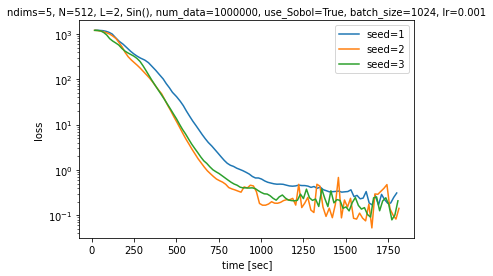

In [ ]:
#@title Compare loss(time) plots
directory = 'ndims=5, seed test'
ndims = 5
N = [512] # number of nodes per hidden layer
L = [2] # number of hidden layers
activation = [Sin()] # activation function
bounds = [0, 1]
num_data = [1000000]
use_sobol = [True] # whether to generate training points using Sobol sequence (True) or uniformly (False)
batch_size = [1024]
lr = [1e-3]
seed = [1, 2, 3]

figure()
for N, L, activation, num_data, use_sobol, batch_size, lr, seed in itertools.product(N, L, activation, num_data, use_sobol, batch_size, lr, seed):
    name = f'{ndims},{N},{L},{activation},{bounds},{num_data},{use_sobol},{batch_size},{lr},{seed}'
    if os.path.isdir(os.path.join(directory, name)):
        with open(os.path.join(directory, name, 'loss(time).csv')) as datafile:
            data = list(csv.reader(datafile, quoting=csv.QUOTE_NONNUMERIC))
        del data[0]
        epoch_data, time_data, loss_data, RMSE_data = zip(*data)
        semilogy(time_data, loss_data, label=f'seed={seed}')
title(f'ndims={ndims}, N={N}, L={L}, {activation}, num_data={num_data}, use_Sobol={use_sobol}, batch_size={batch_size}, lr={lr}', fontsize=10)
xlabel('time [sec]')
ylabel('loss')
legend()
savefig(os.path.join(directory, 'loss(time).pdf'), bbox_inches='tight')

In [ ]:
#@title Reshape model parameters into 1D arrays

# Combine model parameters into single list
print(model.parameters)
weights = torch.Tensor([]).to(device)
biases = torch.Tensor([]).to(device)
layer = model.layers[0]
# for layer in model.layers:
#     if isinstance(layer, nn.Linear):
weights = torch.cat((weights, layer.weight.flatten()))
biases = torch.cat((biases, layer.bias.flatten()))
print(tuple(layer.bias.size()))
print(f'Weights: mean = {torch.mean(weights):.3e}, std = {torch.std(weights):.3e}, min = {torch.min(weights):.3e}, max = {torch.max(weights):.3e}')
print(f'Biases: mean = {torch.mean(biases):.3e}, std = {torch.std(biases):.3e}, min = {torch.min(biases):.3e}, max = {torch.max(biases):.3e}')

fig, axs = subplots(1, 2, figsize=(17/2.54,5/2.54))
fig.suptitle(f'Seed={seed}, layer = 0')
axs[0].hist(weights.cpu().detach(), 100, log=True)
axs[0].set_title('Model weights')
axs[1].hist(biases.cpu().detach(), 100)
axs[1].set_title('Model biases')
savefig(os.path.join(directory, f'hist, seed={seed}, layer = 0.svg'), bbox_inches='tight')

In [ ]:
#@title Simulated annealing
import numpy as np
from scipy import optimize


def simulated_annealing(f, bounds, args=(), max_iter=1000, max_stall_iter=1000, init_temp=1000, restart_temp_ratio=1e-04, seed=None, x0=None):
    rng = np.random.default_rng(seed)
    x = rng.uniform(bounds[:,0], bounds[:,1]) if x0 is None else x0
    y = f(x, *args)
    best_x, best_y = x, y
    num_iter, num_stall_iter, temp_step = 0, 0, 0
    while num_iter < max_iter and num_stall_iter < max_stall_iter:
        new_x = rng.uniform(bounds[:,0], bounds[:,1])
        new_y = f(new_x, *args)
        diff = new_y - y
        temp_step += 1
        temp = init_temp/temp_step
        if diff < 0 or rng.random() < np.exp(-diff/temp):
            x, y = new_x, new_y
            if y < best_y:
                best_x, best_y = x, y
                num_stall_iter = 0
                print(f'iter = {num_iter}, f = {y}')
        num_stall_iter += 1
        if temp < init_temp*restart_temp_ratio:
            temp_step = 0
        num_iter += 1
    return [best_x, best_y]


def obj_fn(params, x):
    model.eval()
    with torch.no_grad():
        i = 0
        for layer in model.layers:
            if isinstance(layer, nn.Linear):
                n = torch.numel(layer.weight)
                layer.weight = nn.Parameter(torch.Tensor(np.reshape(params[i:i+n], layer.weight.size())).to(device))
                i += n
                n = torch.numel(layer.bias)
                layer.bias = nn.Parameter(torch.Tensor(np.reshape(params[i:i+n], layer.bias.size())).to(device))
                i += n
        loss = 0
        for i in range(0, len(x), batch_size):
            x_batch = x[i:i+batch_size]
            pred = model(x_batch)
            loss += loss_fn(model, x_batch, pred, f).item()*len(x_batch)
        loss /= len(x)
    return loss


# Pre-optimization
lb, ub = [], []
for layer in model.layers:
        if isinstance(layer, nn.Linear):
            n = torch.numel(layer.weight)
            lb += [-100]*n
            ub += [100]*n
            n = torch.numel(layer.bias)
            lb += [-10]*n
            ub += [10]*n
bounds = np.array(list(map(list, zip(lb, ub))))
# res = optimize.dual_annealing(obj_fn, bounds, (x_train[0:1000],), maxfun=1000, no_local_search=True)
# print(res)
[x, y] = simulated_annealing(obj_fn, bounds, (x_train[0:1000],))
print(y)

In [ ]:
#@title Different test points
torch.manual_seed(5)
x = (torch.rand(10000, ndims)*(bounds[1] - bounds[0]) + bounds[0]).to(device) # test points
u = torch.prod(torch.sin(2*pi*x), -1, True) # analytical solution
loss, RMSE = test(model, x, u, f, 10000)
print(f'{loss:.3e} | {RMSE:.4f}')